## Documentation
Requirements:

get keras-segmentation with 'pip install keras-segmentation'. Refer to documentation https://github.com/divamgupta/image-segmentation-keras

Useful tutorials:

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html


Directory structure:
TODO

### Handseg dataset:
Width: 640, Height: 480. The annotated images contain three classes: background: 0, right_hand: 1, left_hand: 2.

Accessing the data:

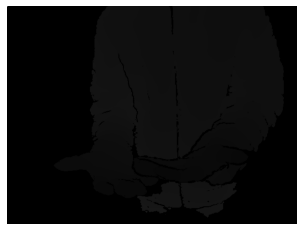

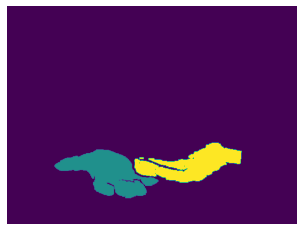

In [16]:
#path to the dataset
handseg_path = '../../../handseg-150k'
#depth_im = np.array(Image.open(Path(handseg_path+'/images/user-8.00008932.png')))# Loading depth image
mask_im = np.array(Image.open(Path(handseg_path+'/masks/user-4.00009545.png')))#  Loading mask image
#depth_im = depth_im.astype(np.float32)# Converting to float
#mean_depth_ims = 10000.0 # Mean value of the depth images
#depth_im /= mean_depth_ims # Normalizing depth image
depth_im = cv2.imread(handseg_path+'/images/user-4.00009545.png')


plt.imshow(depth_im); plt.axis('off'); plt.show() # Displaying Depth Image
plt.imshow(mask_im); plt.axis('off'); plt.show() # Displaying Mask Image

In [4]:
# Library header
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras import Model, Input
from tqdm import tqdm
import shutil #library for moving files
import tensorflow as tf
import numpy as np
import cv2
import glob

# own libraries
import split_dataset as spData
import handseg_model as hand
import handseg_two_classes as hand2
import data_gen as dg


#globals
input_width = 640
input_height = 480
handseg_path = '../../../handseg-150k'

In [2]:
# input is a (480, 640, 2) np.array -> interpret the softmax values in third dimension
def interpretPrediction(pred):
  # create np.array to save the interpretation
  interpretation = np.zeros((480, 640))
  height, width, _ = pred.shape
  for i in range(height):
    for j in range(width):
      # create a list of the probabilites from each class
      value_list = [pred[i,j,0], pred[i,j,1]]
      # find out, which class has been predicted
      largest = max(value_list)
      index_of_largest = value_list.index(largest)
      # store new value in the interpretation array
      interpretation[i,j] = index_of_largest
  return interpretation


def drawBoxes(mask, img):
  # Iterate all colors in mask
  for color in np.unique(mask):

      # Color 0 is assumed to be background or artifacts
      if color == 0:
          continue

      # Determine bounding rectangle w.r.t. all pixels of the mask with
      # the current color
      x, y, w, h = cv2.boundingRect(np.uint8(mask == color))
      print(x,y,w,h)
      # Draw bounding rectangle to color image
      out = cv2.rectangle(img.copy(), (x, y), (x+w, y+h), (255, int(color), 0), 2)

      # Show image with bounding box
      plt.imshow(out); plt.title('img_' + str(color)); plt.show()

        
def getIOU(predicted, ground_truth):
    # IoU calculation
    intersection = np.logical_and(ground_truth, predicted)
    union = np.logical_or(ground_truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    print("IoU is ", iou_score)

# preprocessing
def preprocess(img):
    return (img / img.max()) * 255

In [10]:
# returns a list of tupels containing the values for iou and accuracy
# since the metrics are updated in each step, the las tupel value containst the
# final result
def eval_handseg():
  # path values for test data
  paths_test_images = glob.glob(handseg_path+"/test_images/*.png")
  paths_test_mask = glob.glob(handseg_path+"/test_masks/*.png")

  # create the respective metrics
  metric_iou = tf.keras.metrics.MeanIoU(num_classes=2)
  metric_acc = tf.keras.metrics.Accuracy()

  # initialize list
  result = []

  for i in tqdm(range(len(paths_test_images))):
    # load the img
    in_image = cv2.imread(paths_test_images[i])
    in_image = np.reshape(in_image, (1,480, 640, 3))
    # apply preprocessing
    in_image = preprocess(in_image)
    # predict
    out_im = handseg.predict(in_image)
    # interpret prediction
    out_im = interpretPrediction(out_im[0])
    # calculate IoU and accuracy
    gt = cv2.imread(paths_test_mask[i])
    
    # do this for two classes
    gt = tf.where(gt == 2, 1, gt).numpy()
    
    metric_iou.update_state(gt[:,:,0], out_im)
    metric_acc.update_state(gt[:,:,0], out_im)
    # append tupel to list
    result.append((metric_iou.result().numpy(), metric_acc.result().numpy()))

  return result

handseg.load_weights("../../../results/weights/twoClasses/handseg_model_twoClasses_4.h5")
res = eval_handseg()
print(res.last[-1])

  0%|                                                                              | 9/28440 [00:08<7:51:55,  1.00it/s]


KeyboardInterrupt: 

In [ ]:
# create the data generators with data_loader
# ... for training
train_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/images/",
        segs_path=handseg_path+"/masks/", 
        batch_size=16,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        do_augment=True,
        preprocessing=preprocess,
        read_image_type=1)
# read_image_type -> 0 = grayscale; -> 1 = rgb

# ... for validation
val_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/val_images/",
        segs_path=handseg_path+"/val_masks/",
        batch_size=2,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        preprocessing=preprocess,
        read_image_type=1)

# ... for testing
test_gen = dg.image_segmentation_generator(
        images_path=handseg_path+"/test_images/",
        segs_path=handseg_path+"/test_masks/",
        batch_size=2,
        n_classes=3,
        input_height=480,
        input_width=640,
        output_height=480,
        output_width=640,
        preprocessing=preprocess,
        read_image_type=1)

In [8]:
# Initialize the model
inputs = Input(shape=(480, 640, 3))
handseg = Model(inputs=inputs, outputs=hand2.handseg_model(inputs), name="HandSeg_Model")
handseg.summary()

# build the segmentation model
handseg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])

Model: "HandSeg_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 240, 320, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 240, 320, 64) 0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 120, 160, 128 73856       leaky_re_lu_4[0][0]              
______________________________________________________________________________________

In [3]:
from keras.utils.vis_utils import plot_model

plot_model(handseg, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [4]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Mosquito\miniconda3\python.exe -m pip install --upgrade pip' command.


(1, 480, 640, 3)


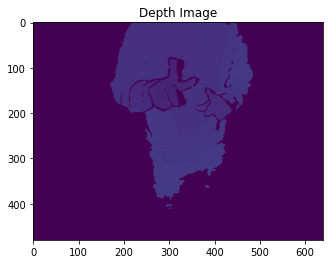

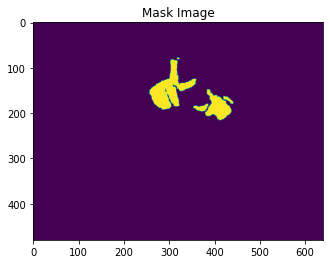

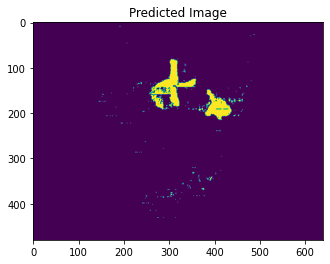

IoU value:  0.8533555


In [28]:
handseg.load_weights("../../../results/weights/twoClasses/handseg_model_twoClasses_3.h5")



image_path = "/test_images/user-2.00000486.png"
mask_path = "/test_masks/user-2.00000486.png"

depth_im = np.array(Image.open(Path(handseg_path+image_path)))
mask_im = np.array(Image.open(Path(handseg_path+mask_path)))
mask_im = tf.where(mask_im == 2, 1, mask_im).numpy()

in_image = cv2.imread(handseg_path+image_path)
in_image = np.reshape(in_image, (1,480, 640, 3))
in_image = preprocess(in_image)
print(in_image.shape)
out_im = handseg.predict(in_image)
out_im = interpretPrediction(out_im[0])

plt.imshow(depth_im); plt.title('Depth Image'); plt.show()
plt.imshow(mask_im); plt.title('Mask Image'); plt.show()
plt.imshow(out_im); plt.title('Predicted Image'); plt.show()


m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(mask_im, out_im)
print("IoU value: ", m.result().numpy())

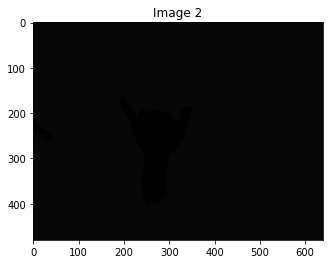

(480, 640, 3)


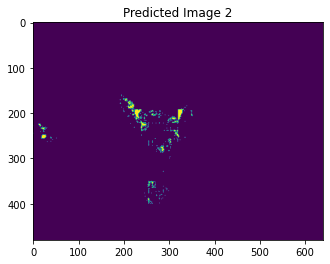

(480, 640, 3) (480, 640, 2)
0.4401667
0 160 352 240


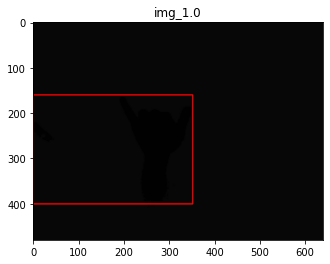

In [19]:
handseg.load_weights("../../../results/weights/twoClasses/handseg_model_twoClasses_2.h5")


im_2 = cv2.imread(handseg_path+"/predict/depth_1_0000045.png")
im_2 = cv2.resize(im_2, (640, 480))
plt.imshow(im_2); plt.title('Image 2'); plt.show()
print(im_2.shape)
im_2 = np.reshape(im_2, (1,480, 640, 3))
im_2 = preprocess(im_2)
out_im_2 = handseg.predict(im_2)
out_im_2_pred = interpretPrediction(out_im_2[0])
plt.imshow(out_im_2_pred); plt.title('Predicted Image 2'); plt.show()

# check iou
gt = cv2.imread(handseg_path+mask_path)
m = tf.keras.metrics.MeanIoU(num_classes=3)

print(gt.shape, pred[0].shape)

m.update_state(gt[:,:,0], interpretPrediction(pred[0]))
print(m.result().numpy())

# draw box
im_3 = cv2.imread(handseg_path+"/predict/depth_1_0000045.png")
im_3 = cv2.resize(im_3, (640, 480))
drawBoxes(out_im_2_pred, im_3)

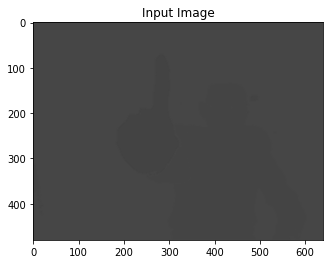

66 71


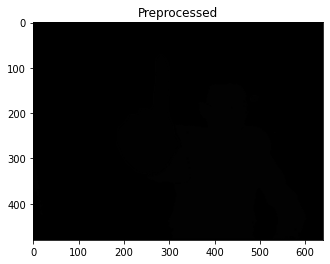

0 0 5 [0 1 2 3 5]


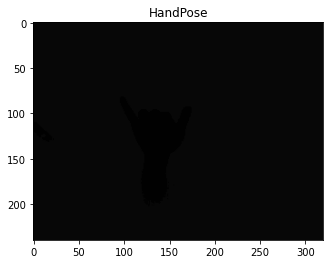

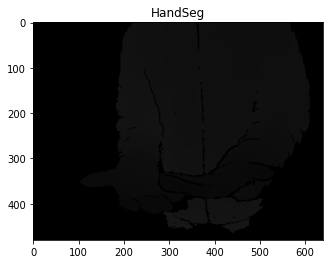

[0. 1.]


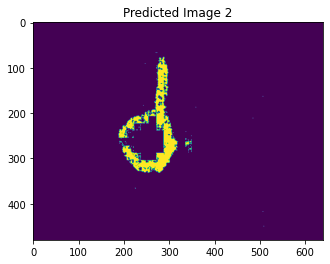

188 67 322 383


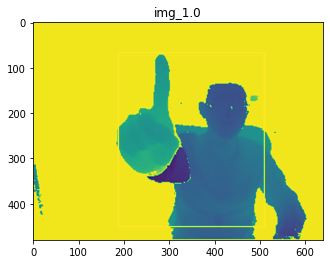

In [174]:
handseg.load_weights("../../../results/weights/twoClasses/handseg_model_twoClasses_1.h5")

def preprocess2(img):
    img = img - img.min()
    #img = img.max() - img
    return img


depth_seg = cv2.imread(handseg_path+'/images/user-4.00009545.png')
depth_pose = cv2.imread(handseg_path+'/predict/depth_1_0000045.png')

# load image
depth_map = cv2.imread("./test_depth.png")
plt.imshow(depth_map); plt.title('Input Image'); plt.show()
print(depth_map.min(), depth_map.max())

# Preprocessing
depth_map = preprocess2(depth_map)
depth_map = tf.where(depth_map == 4, 0, depth_map).numpy()
plt.imshow(depth_map, cmap="gray_r"); plt.title('Preprocessed'); plt.show()
print(depth_map[0,0,0], depth_map.min(), depth_map.max(), np.unique(depth_map))
plt.imshow(depth_pose, cmap="gray_r"); plt.title('HandPose'); plt.show()
plt.imshow(depth_seg, cmap="gray_r"); plt.title('HandSeg'); plt.show()

#depth_map = cv2.fastNlMeansDenoisingColored(depth_map,None,100,10,7,21)
#plt.imshow(depth_map); plt.title('After denoising'); plt.show()

im = np.reshape(depth_map, (1,480, 640, 3))
out_im = handseg.predict(im)
out_im_pred = interpretPrediction(out_im[0])
print(np.unique(out_im_pred))
plt.imshow(out_im_pred); plt.title('Predicted Image 2'); plt.show()

# draw box
name = "./S01_C01_0025.bin"
ground = np.fromfile(name, dtype='uint8')
ground = ground.reshape(240,320,4)
ground = cv2.resize(ground, dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
drawBoxes(out_im_pred, ground[:,:,2])

(307200,)


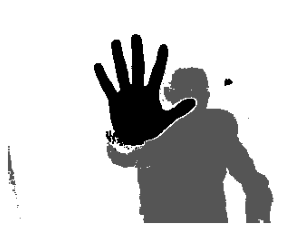

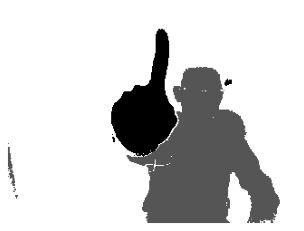

In [43]:
# read binary file
name = "./S01_C01_0000.bin" 
name2 = "./S01_C01_0025.bin"
name3 = "./S01_C05_0190.bin"

depth_map = np.fromfile(name3, dtype='uint8')
depth_map_1 = np.fromfile(name, dtype='uint8')
print(depth_map.shape)
depth_map = depth_map.reshape(240,320,4)
depth_map_1 = depth_map_1.reshape(240,320,4)
#cv2.imwrite('bash1.png', depth_map[0])
plt.imshow(depth_map[:,:,3], cmap="gray"); plt.axis('off'); plt.show()
plt.imshow(depth_map_1[:,:,3], cmap="gray"); plt.axis('off'); plt.show()
#hot, gray_r

(240, 320, 4)


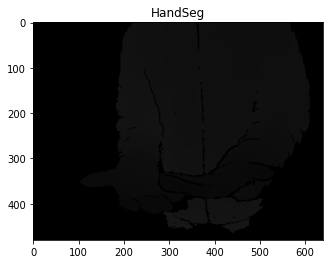

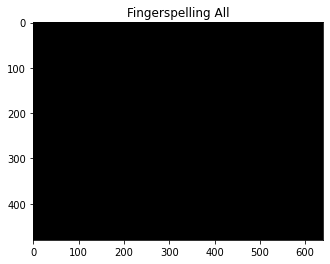

0.0


In [147]:
# preprocessing
def preprocess(img):
    return (img / img.max()) * 255

name = "./S01_C01_0025.bin"
depth_im = cv2.imread(handseg_path+'/images/user-4.00009545.png')
depth_im_2 = cv2.imread(handseg_path+'/predict/depth_1_0000045.png')


depth_map = np.fromfile(name, dtype='uint8')
depth_map = depth_map.reshape(240,320,4)
print(depth_map.shape)

temp_map_1 = cv2.resize(depth_map[:,:,0], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
temp_map_2 = cv2.resize(depth_map[:,:,1], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
temp_map_3 = cv2.resize(depth_map[:,:,2], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
temp_map_4 = cv2.resize(depth_map[:,:,3], dsize=(640, 480), interpolation=cv2.INTER_CUBIC)

#temp_map_5 = cv2.resize(depth_map, dsize=(640, 480), interpolation=cv2.INTER_AREA)

img_depth = np.zeros((480,640,3))

#temp_map_4 = preprocess(temp_map_3)
cv2.imwrite('test_depth.png',temp_map_4)
plt.imshow(depth_im); plt.title("HandSeg"); plt.show()
plt.imshow(img_depth); plt.title("Fingerspelling All"); plt.show()
print(img_depth[0,0,0])

(480, 640, 3) 0 255


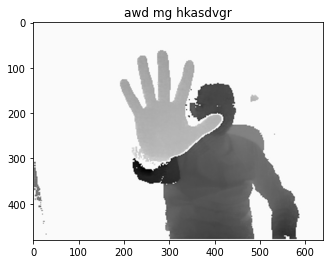

Selected value:  181


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [52]:
# preprocessing
def preprocess(img):
    return (img / img.max()) * 255

depth = cv2.imread("./test_depth.png")
print(depth.shape, depth.min(), depth.max())
plt.imshow(depth); plt.title("awd mg hkasdvgr"); plt.show()
print("Selected value: ",depth[250,300,0])

depth = tf.where(depth == 250, 0, depth).numpy()
depth = tf.where(depth > 170 and depth < 200, 20, depth).numpy()

print(depth.shape, depth.min(), depth.max())
plt.imshow(depth); plt.title("Preprocessed"); plt.show()

In [11]:
somelist = [1.2, 3.3, 4.2]
print(sum(somelist))

8.7
